# Data Prep For Training TF-IDF and Word2Vec Model

Here we will prepare the input dataset(X, Y) which will be used for training a NN model using Word2Vec representations and generating symptom representation using TF-IDF weights.

---

- Input  : symptoms.csv file generated by Symptom Extraction Module.
- Input  : DIAGNOSES_ICD.csv from MIMIC-III Dataset
- Output : symptom_disease_dict_{RUN_TAG}.json - Contains HADM_ID to Symptom text and Diagnosis mapping as json object
- Output : icd9_dict_{RUN_TAG}.json - Contains ICD9 Codes of TOP N Diagnoses
- Output : symptoms_dict{RUN_TAG}.json - Symptoms Dictionary with count of each symptom

In [6]:
import pandas as pd
import os
import numpy as np
import json
import matplotlib.pyplot as plt

### Load Symptoms and Diagnoses Data

Here we will load symptoms extracted from the discharge summary notes using MetaMap. Also we will load the DIAGNOSES table which contains patient diagnosis for each hospital admission in the MIMIC III dataset.

In [7]:
cwd = os.getcwd()
print(f"Current working directory : {cwd}")
# Let's define some constants that will be used below in our processing
MAX_NUMBER_OF_DISEASE = 100
RUN_TAG = "_100_v2.0"
data_dir = cwd + "/../../data/"
SYMPTOM_DISEASE_DICT_FILE_PATH = data_dir + f"symptom_disease_dict_{RUN_TAG}.json"
ICD9_FILE_PATH = data_dir + f"icd9_dict_{RUN_TAG}.json"
SYMPTOM_DICT_FILE_PATH = data_dir + f"symptoms_dict_{RUN_TAG}.json"

Current working directory : /Users/vijaymi/Studies/CS-598-DL4Health/Project/135-Disease-Inference-Method/disease_pred_using_bilstm/source


In [8]:
# data directory contains all the data files used in this project.


# symptoms.csv file is generated by Symptom Extraction Module (symptom_extraction.ipynb)
symptoms_df = pd.read_csv(data_dir + "symptoms.csv")
print('Total discharge notes with symptoms extracted: ', len(symptoms_df.index))
symptoms_df.head()

Total discharge notes with symptoms extracted:  59651


,INDEX,ROW_ID,SUBJECT_ID,HADM_ID,SYMPTOMS
0,61,208,5239,125055.0,Autoimmune hemolytic anemia|Dyspnea|Congestive...
1,62,209,5239,125055.0,Hydrocephalus Normal Pressure|Congestive hear...
2,63,210,21449,139542.0,Acute Chest Syndrome|Hypertensive disease|Hype...
3,64,211,40273,124821.0,Obesity|Chronic Kidney Diseases|Hypertensive d...
4,65,212,76874,113329.0,Benign Rolandic Epilepsy|Sleeplessness|Familia...


In [9]:
# Load the table that has the dignosis codes for each hospital visit for a patient. 
diagnoses_df = pd.read_csv(data_dir + "DIAGNOSES_ICD.csv")
# We will just take the first three digits of the ICD code and not worry about sub-diseases
diagnoses_df['ICD9_3CHAR'] = diagnoses_df['ICD9_CODE'].str[:3]

# Use only needed columns, and drop others
diagnoses_df = diagnoses_df.drop(["ICD9_CODE", "SEQ_NUM", "ROW_ID"], axis=1)
diagnoses_df = diagnoses_df.drop_duplicates()
diagnoses_df.head()

,SUBJECT_ID,HADM_ID,ICD9_3CHAR
0,109,172335,403
1,109,172335,486
2,109,172335,582
3,109,172335,585
4,109,172335,425


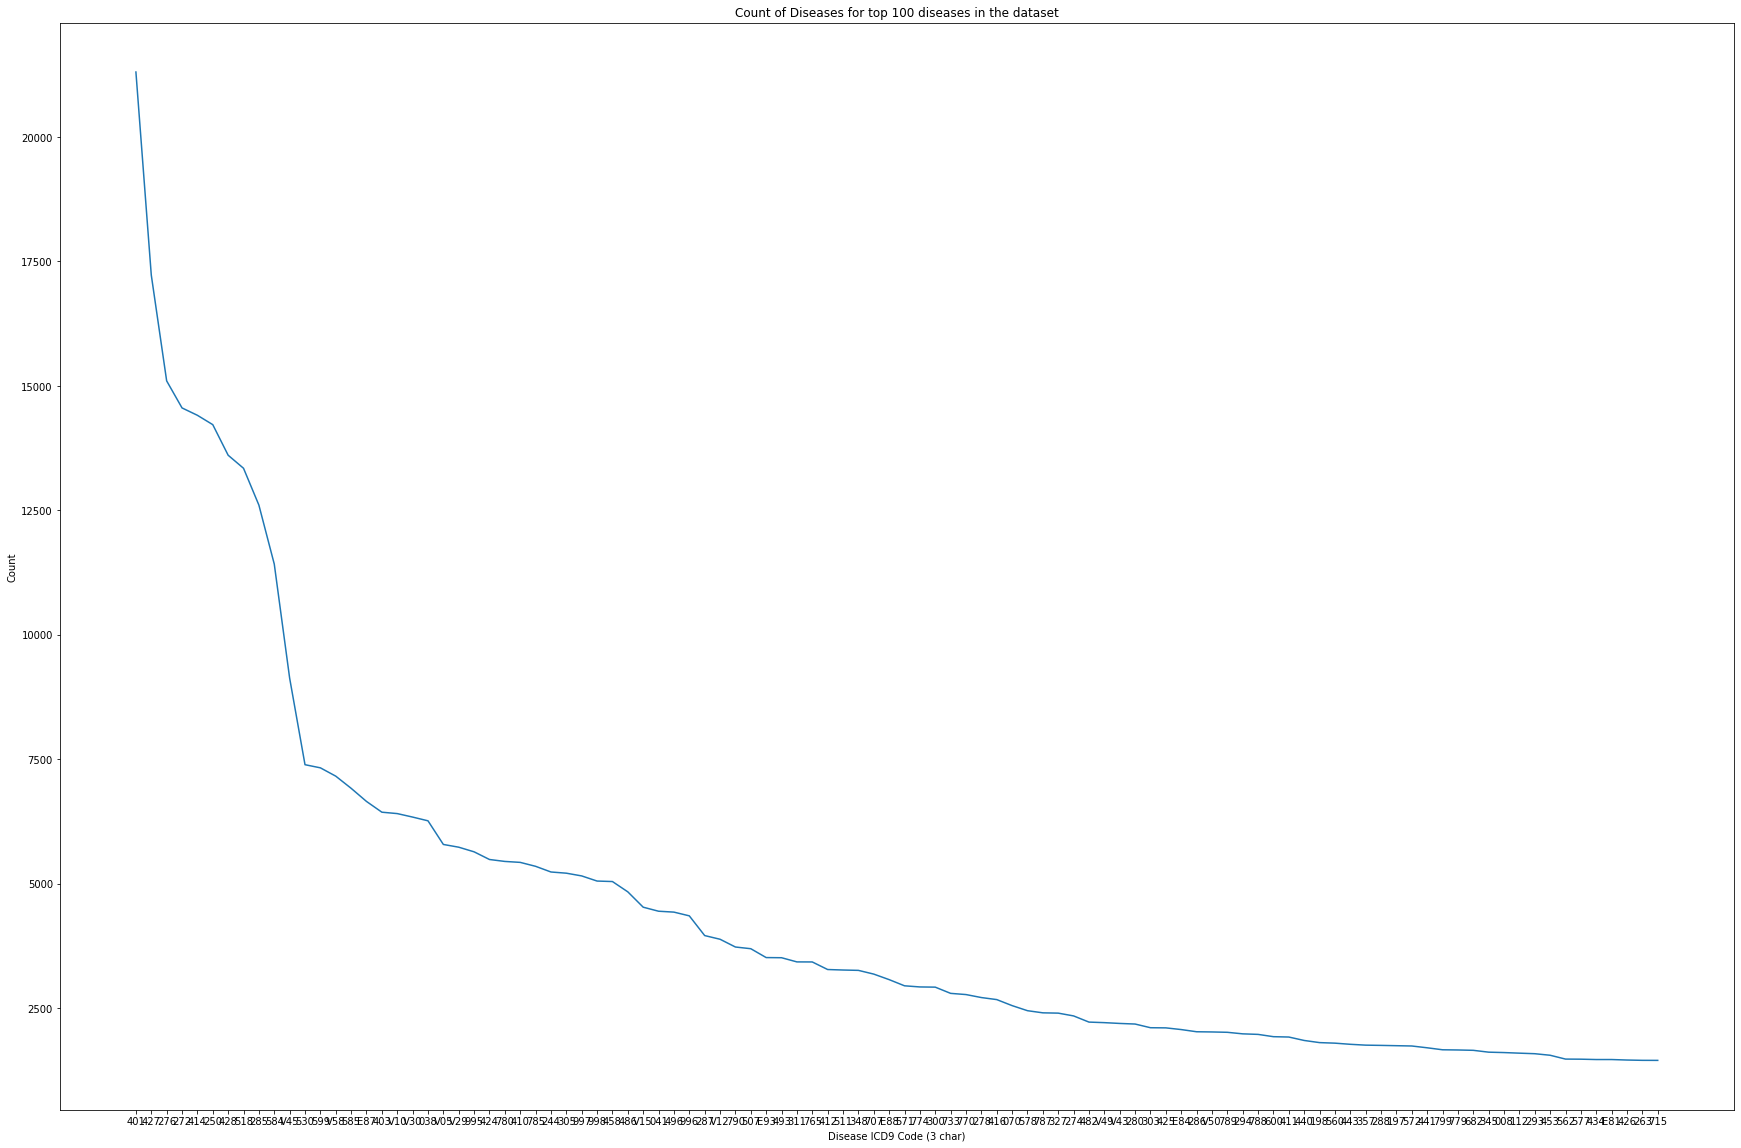

In [10]:
# Let's look a Diagonses Data
top_diag = diagnoses_df.groupby(['ICD9_3CHAR'])['ICD9_3CHAR'].count().sort_values(ascending=False)
fig = plt.figure(figsize=(30,20))
plt.title(f"Count of Diseases for top {MAX_NUMBER_OF_DISEASE} diseases in the dataset")
plt.xlabel('Disease ICD9 Code (3 char)')
plt.ylabel('Count')
plt.plot(top_diag.index[:MAX_NUMBER_OF_DISEASE], top_diag[:MAX_NUMBER_OF_DISEASE])

### Join Symptoms and Diagnosis

Here we will join the symptoms and dignoses tables on the hospital admission ID (HADM_ID). So now we will have information on what sysmptoms led to what disease diagnosis for each hospital admission for the patient.

In [11]:
# Join symptoms and disease data frames
symp_diag_df = symptoms_df.set_index('HADM_ID').join(diagnoses_df.set_index('HADM_ID'), lsuffix='_symp', rsuffix='_diag')
symp_diag_df = symp_diag_df.reset_index()

# Rename the subject ID column and take only needed columns
symp_diag_df.rename(columns={'SUBJECT_ID_symp': 'SUBJECT_ID'}, inplace=True)
symp_diag_df = symp_diag_df[['SUBJECT_ID', 'HADM_ID', 'SYMPTOMS', 'ICD9_3CHAR']]

# Drop duplicates and filter out NAN rows for HADM_ID
symp_diag_df = symp_diag_df.drop_duplicates()
symp_diag_df = symp_diag_df[symp_diag_df['HADM_ID'].notnull()]

# Convert the HADM_ID column to int
symp_diag_df.HADM_ID = symp_diag_df.HADM_ID.astype(int)
print(f"symp_diagnoses.shape : {symp_diag_df.shape}")

# Group by disease count and count the number of unique diseases
# Note: here we get count as 936, the paper has the total count as 931
disease_count = symp_diag_df.groupby(['ICD9_3CHAR'])['ICD9_3CHAR'].count()
print(f"disease_count.shape : {disease_count.shape}")
symp_diag_df.head()


symp_diagnoses.shape : (618695, 4)
disease_count.shape : (941,)


,SUBJECT_ID,HADM_ID,SYMPTOMS,ICD9_3CHAR
0,58526,100001,Diabetic Ketoacidosis|Vomiting|Hypertensive di...,250
1,58526,100001,Diabetic Ketoacidosis|Vomiting|Hypertensive di...,337
2,58526,100001,Diabetic Ketoacidosis|Vomiting|Hypertensive di...,584
3,58526,100001,Diabetic Ketoacidosis|Vomiting|Hypertensive di...,578
4,58526,100001,Diabetic Ketoacidosis|Vomiting|Hypertensive di...,V58


### Filter Top N Diseases and Related Symptoms in the Notes

In [12]:
top_diag_df = symp_diag_df.groupby(['ICD9_3CHAR'])['ICD9_3CHAR'].count().sort_values(ascending=False)
# taking only top 50 diseases
top_n_diag_df = top_diag_df[:MAX_NUMBER_OF_DISEASE]
print(f"top_50_diagnoses.shape : {top_n_diag_df.shape}")
top_n_diag_df.head()

top_50_diagnoses.shape : (100,)


ICD9_3CHAR
401    22391
427    18651
276    16015
414    15459
272    15256
Name: ICD9_3CHAR, dtype: int64

**Let's look at symp_diag_df and it's columns. We want to filter records from this DataFrame which is associated with top N diagnoses**

In [13]:
print(f"symp_diag_df.shape : {symp_diag_df.shape}")
symp_diag_df.head()

symp_diag_df.shape : (618695, 4)


,SUBJECT_ID,HADM_ID,SYMPTOMS,ICD9_3CHAR
0,58526,100001,Diabetic Ketoacidosis|Vomiting|Hypertensive di...,250
1,58526,100001,Diabetic Ketoacidosis|Vomiting|Hypertensive di...,337
2,58526,100001,Diabetic Ketoacidosis|Vomiting|Hypertensive di...,584
3,58526,100001,Diabetic Ketoacidosis|Vomiting|Hypertensive di...,578
4,58526,100001,Diabetic Ketoacidosis|Vomiting|Hypertensive di...,V58


In [14]:
# Filter symptom data which corresponds to top 50 diseases
symp_diag_top_n_df = (symp_diag_df[symp_diag_df.ICD9_3CHAR.isin(top_n_diag_df.index)]).copy()
print(f"symp_diag_top_n_df.shape : {symp_diag_top_n_df.shape}")
symp_diag_top_n_df.SYMPTOMS = symp_diag_top_n_df.SYMPTOMS.astype(str)
symp_diag_top_n_df = symp_diag_top_n_df.reset_index() 
symp_diag_top_n_df.head()

symp_diag_top_n_df.shape : (464843, 4)


,index,SUBJECT_ID,HADM_ID,SYMPTOMS,ICD9_3CHAR
0,0,58526,100001,Diabetic Ketoacidosis|Vomiting|Hypertensive di...,250
1,2,58526,100001,Diabetic Ketoacidosis|Vomiting|Hypertensive di...,584
2,3,58526,100001,Diabetic Ketoacidosis|Vomiting|Hypertensive di...,578
3,4,58526,100001,Diabetic Ketoacidosis|Vomiting|Hypertensive di...,V58
4,6,58526,100001,Diabetic Ketoacidosis|Vomiting|Hypertensive di...,458


### Filter Symptoms and Create HADM_ID <-> Symptom Indices Map

Note: computation below is a little slow and may take couple of minutes.

In [15]:
IGNORE_SYMPTOMS = ["disease", "symptoms", "signs and symptoms", "communicable diseases", "symptom", "diseases"]
# Dictionary which contains the index of the symptom as well as total count across all discharge notes
symptom_total_count_dict = {}
# HADM_ID set to keep track of duplicate processing
hadm_id_set = set()
# This loop is to collect all symptoms, assign them id, and their total count
for index, record in symp_diag_top_n_df.iterrows():
    # Get hadm_id
    hadm_id = record['HADM_ID']
    # Skip if we have already processed this hadm_id
    if hadm_id in hadm_id_set:
        continue
    else:
        # Add this hadm_id as processed
        hadm_id_set.add(hadm_id)
    
    symp_list = record['SYMPTOMS'].split("|")
    # only consider notes with symptoms count more than 1
    if len(symp_list) > 1:
        for symptom in symp_list:        
            if symptom not in symptom_total_count_dict:
                symptom_total_count_dict[symptom] = 1
            else:
                symptom_total_count_dict[symptom] += 1
    
# In this loop we will filter symptoms based on IGNORE_SYMPTOMS and those with frequency < 10
filtered_symptom_dict = {}
# A hadm_id to symptom index map, which has for each hadm_id what are the associated symptom indices
hadm_symp_map = {}
symptom_index = 0
symp_count_stat = [0] * 200
for index, record in symp_diag_top_n_df.iterrows():
    # Get hadm_id
    hadm_id = record['HADM_ID']
    symp_index_list = []
    # Skip if we have already processed this hadm_id
    if hadm_id in hadm_symp_map:
        continue
    
    symp_list = record['SYMPTOMS'].split("|")
    # only consider notes with symptoms count more than 1
    if len(symp_list) > 1:
        # symp_count_stat is just for understanding data. It is not used in any processing.
        symp_count_stat[len(symp_list)] += 1
        
        for symptom in symp_list:
            # Filter symtoms in ignore list and those which total frequency < 10
            if symptom.lower() in IGNORE_SYMPTOMS or symptom_total_count_dict[symptom] < 10:
                continue
            
            # Assign an index to the filtered symptom if it does not already have one
            if symptom not in filtered_symptom_dict:
                filtered_symptom_dict[symptom] = symptom_index
                symptom_index += 1
            # This is a list of symptom indices for a particular hadm_id
            symp_index_list.append(filtered_symptom_dict[symptom])
    hadm_symp_map[hadm_id] = symp_index_list

# Total number of symptoms
number_of_symptoms = len(filtered_symptom_dict)
            
print(f"total unique symptoms : {number_of_symptoms}")
# filtered_symptom_dict

total unique symptoms : 4026


**Following charts shows frequency of symptom count in various discharge notes. From the chart below, one can see that most of the discharge summary text have 20-40 symptoms associated with them. It also shows that there is significant amount of discharge summary notes with more than 50 symptoms** 

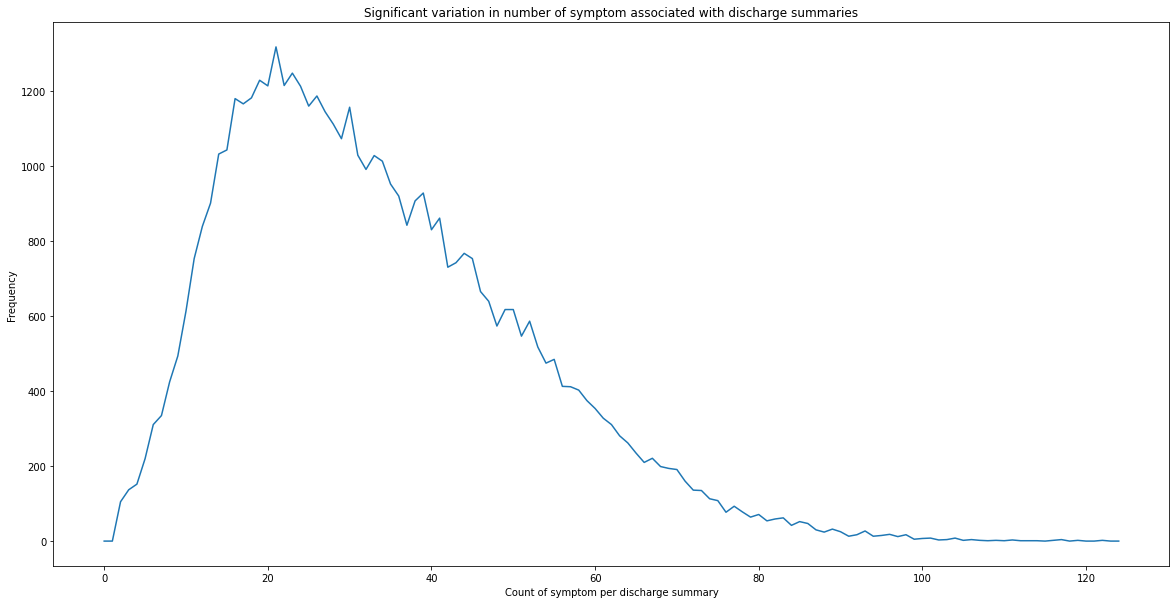

In [16]:
fig = plt.figure(figsize=(20,10))
plt.title(f"Significant variation in number of symptom associated with discharge summaries")
plt.xlabel('Count of symptom per discharge summary')
plt.ylabel('Frequency')
plt.plot(symp_count_stat[:125])

### Create Symptoms <-> Diseases Mapping for each HADM_ID

In [17]:
# Create a dictionary of HADM_ID -> {symptoms[], diseases[]}
# These will become the inputs and outputs when training the neural network

symptom_disease_dict = {}
# print(len(symp_diag_top_n_df))

# For each record in the dataframe, we have multiple rows with same HADM_ID and symptom list
# but the diseases for that HADM_ID are listed in separate rows. Here we will collect those diseases
# so that for each hospital admission, we have symptoms and diseases in one place, i.e. a tuple of
# <symptom_list, disease_list>.
for index, record in symp_diag_top_n_df.iterrows():
    hadm_id = record['HADM_ID']
    # Check if this id exists in the dictionary
    if hadm_id in symptom_disease_dict.keys():
        # Get symptoms, diseases tuple from the dictionary
        symp_disease_tuple = symptom_disease_dict.get(hadm_id)
        # Get the disease list
        disease_list = symp_disease_tuple[1]
        # Add this disease ICD code to the list of diseases for this HADM_ID
        # i.e. collect diseases for this HADM_ID
        disease_list.append(record['ICD9_3CHAR'])
    elif hadm_id not in symptom_disease_dict.keys():
        # Create the value entry for this hadm_id key
        symp_list = record['SYMPTOMS'].split("|")
        # For notes containing more than 1 symptom
        if len(symp_list) > 1:
            disease_list = []
            disease_list.append(record['ICD9_3CHAR'])
            symptom_disease_dict[hadm_id] = (symp_list, disease_list)
            
print(f"Length of symptom_disease_dict dictionary : {len(symptom_disease_dict)}")

Length of symptom_disease_dict dictionary : 50392


In [18]:
# We will have to sort the symptom list based on frequency of occurrence for the diseases in the diseases list
sample_hadm_id = list(symptom_disease_dict.keys())[0]
print(f"Record for HADM_ID {sample_hadm_id} is {json.dumps(symptom_disease_dict[sample_hadm_id], indent=4)}")

Record for HADM_ID 100001 is [
    [
        "Diabetic Ketoacidosis",
        "Vomiting",
        "Hypertensive disease",
        "Gastroparesis",
        "Chronic Kidney Diseases",
        "Nausea",
        "Kidney Diseases",
        "Pain",
        "Retinal Diseases",
        "Hypotension  Orthostatic",
        "Diabetes Mellitus  Insulin-Dependent",
        "Diabetic Nephropathy",
        "Coffee ground vomiting",
        "Diabetes Mellitus",
        "Heartburn",
        "POPLITEAL PTERYGIUM SYNDROME  LETHAL TYPE",
        "Discharge  body substance",
        "Sex Differentiation Disorders",
        "Diarrhea",
        "Chills",
        "Pleural effusion disorder",
        "Pulmonary Edema",
        "Neuropathy",
        "Disease",
        "Pneumonia",
        "Nuclear non-senile cataract",
        "Acute-on-chronic renal impairment",
        "Autonomic neuropathy",
        "Diabetes",
        "Dyspnea on exertion",
        "Heparin-induced thrombocytopenia",
        "SHORT STATURE 

### Save the Disease Index and Symptom <-> Disease Mapping to Files

In [19]:
# Save the symptom disease dictionary to a file
with open(SYMPTOM_DISEASE_DICT_FILE_PATH, 'w') as f:
    json.dump(symptom_disease_dict, f)

In [20]:
# Save ICD9 code to index mapping in a dictionary
icd9_dict = {}
for i, item in enumerate(top_n_diag_df.index):
    icd9_dict[item] = i
# print(icd9_dict)

# Save the diagnoses to index mapping dictionary to a file
with open(ICD9_FILE_PATH, 'w') as f:
    json.dump(icd9_dict, f)
    
with open(SYMPTOM_DICT_FILE_PATH, 'w') as f:
    json.dump(filtered_symptom_dict, f) 

### Some Extra plots to help us understand data better

#### Histogram showing frequency of number of diagnosis code per admission

Based on the histogram, one can see that diagnoses per admission can vary from 1 to 38 with most around 10 diagnoses codes.

(array([4.700e+01, 3.890e+02, 1.121e+03, 3.053e+03, 3.747e+03, 3.934e+03,
        4.162e+03, 4.746e+03, 5.816e+03, 6.581e+03, 2.945e+03, 2.838e+03,
        2.743e+03, 2.484e+03, 2.287e+03, 2.035e+03, 1.817e+03, 1.545e+03,
        1.275e+03, 1.116e+03, 9.000e+02, 7.020e+02, 5.510e+02, 4.490e+02,
        3.750e+02, 3.100e+02, 2.410e+02, 1.780e+02, 1.470e+02, 1.110e+02,
        9.800e+01, 6.400e+01, 6.400e+01, 5.400e+01, 3.100e+01, 1.300e+01,
        4.000e+00, 1.000e+00, 1.000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39.]),
 <BarContainer object of 39 artists>)

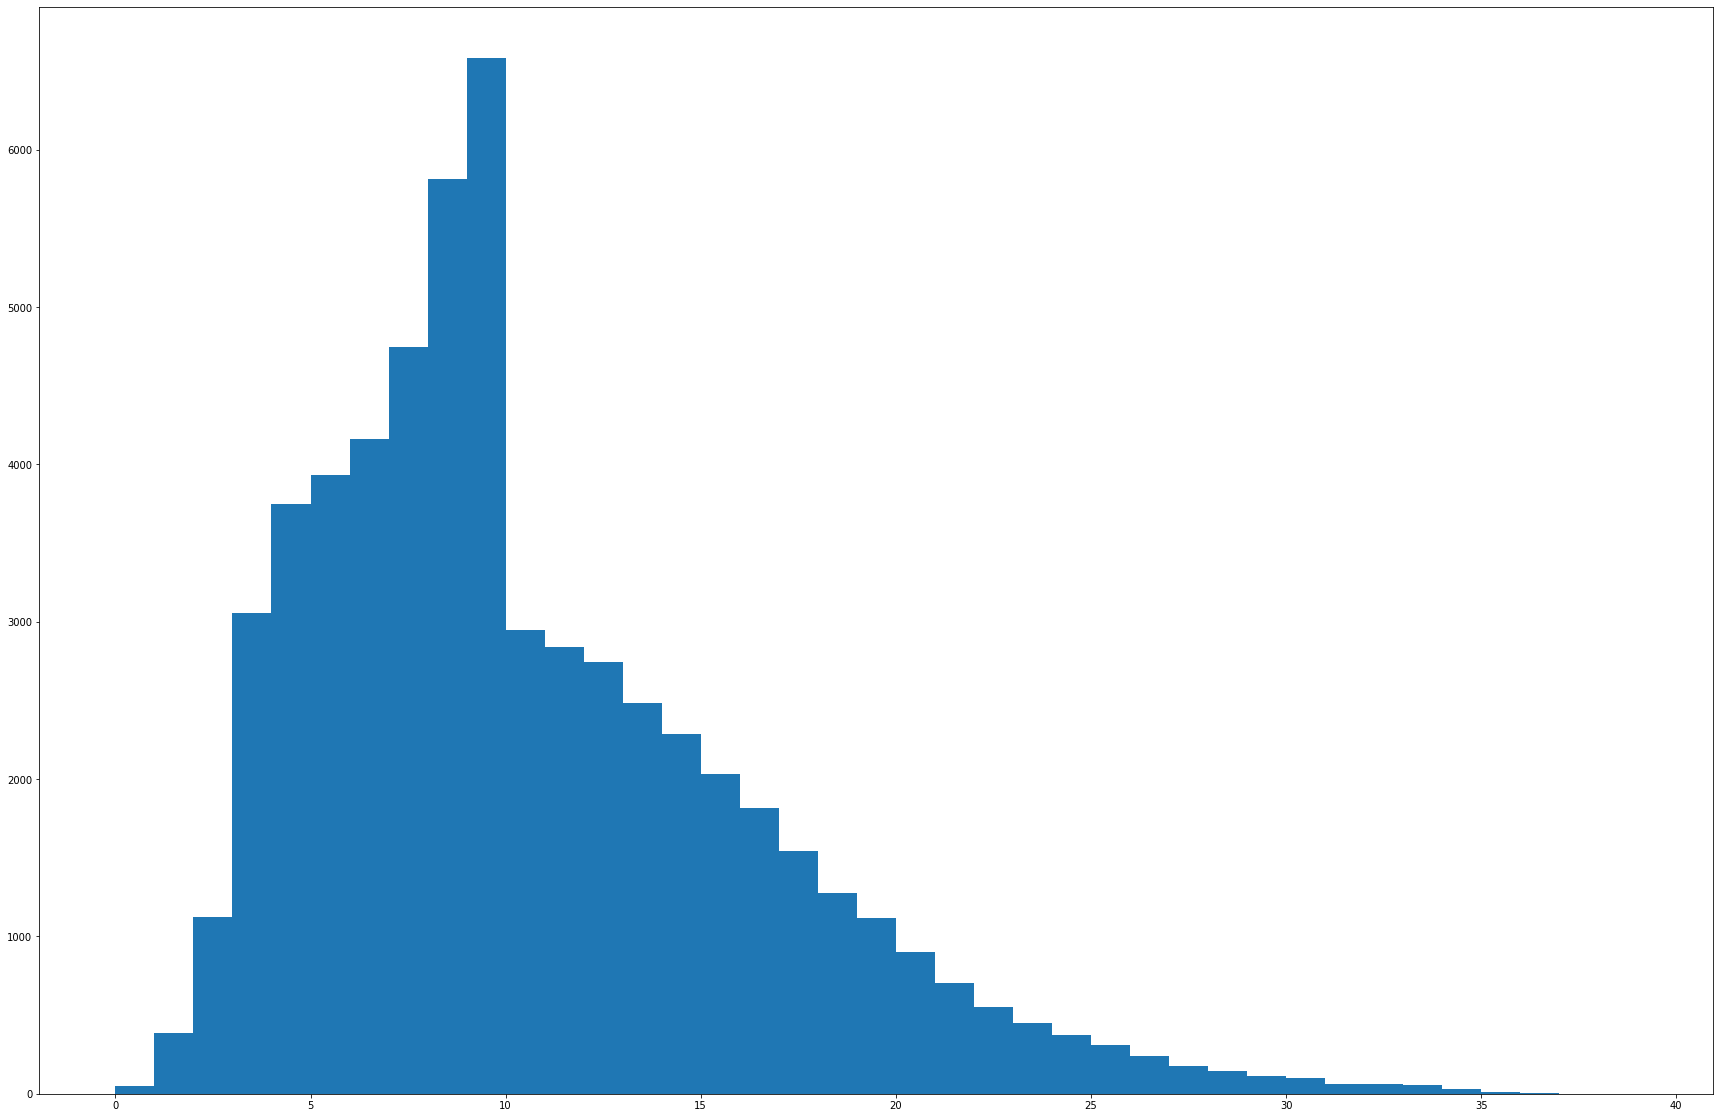

In [21]:
diag_count_by_admission = diagnoses_df.groupby(['HADM_ID'], as_index=False)['ICD9_3CHAR'].count()
diag_by_adm = diag_count_by_admission.groupby(['ICD9_3CHAR'], as_index=False)['ICD9_3CHAR'].count()
plt.figure(figsize=(30,20))
plt.hist(diag_count_by_admission['ICD9_3CHAR'][:-1], bins=len(diag_by_adm))